In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
from sklearn import tree
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
tqdm.pandas()

# MLB Results

#### Load the data

In [25]:
dat= pd.read_hdf(f'/Users/annaa/Documents/data/2019GenericData.hdf')

#### Split the data into observation window and follow up window

In [8]:
# Observation Window
obStart=pd.to_datetime('1999-01-01')
obEnd=pd.to_datetime('2013-12-31')

#Followup Window
ffStart=pd.to_datetime('2014-01-01')
ffEnd=pd.to_datetime('2014-12-31')

In [9]:
def TimelineSummary(tbl,startDate='NoDate',endDate='NoDate'):
    if startDate != 'NoDate' and endDate != 'NoDate':
        tbl = tbl.loc[ (tbl.Date >= startDate) & (tbl.Date <= endDate) ]
        
    return pd.Series({
        'NumReferral': (tbl.Event == 'Referral').sum(),
        'NumStay': (tbl.Event == 'Stay').sum(),
        'NumMajorEvent': (tbl.Event == 'MajorEvent').sum(),
        'NumAdverseOutcome': (tbl.Event == 'AdverseOutcome').sum(),
       
    })

In [10]:
obFtr = dat.groupby(level=0).progress_apply(TimelineSummary,startDate=obStart,endDate=obEnd)

ffFtr = dat.groupby(level=0).progress_apply(TimelineSummary,startDate=ffStart,endDate=ffEnd)

  0%|          | 0/915 [00:00<?, ?it/s]

  0%|          | 0/915 [00:00<?, ?it/s]

In [7]:
# ffFtr['NumAdverseOutcome'].unique()
# (ffFtr['NumAdverseOutcome'] != 0).sum()

#Replace all non-zeros in NumAdverseOutcome column with ones.

# ffFtr['NumAdverseOutcome'] = ffFtr['NumAdverseOutcome'].where(ffFtr['NumAdverseOutcome'] == 0, 1)

#### Extract the labels and the features

In [11]:
labels= ffFtr['NumAdverseOutcome']
features = obFtr.drop(labels=[ "NumAdverseOutcome"], axis=1)

# split data into training set(70%) and test set(30%)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=.3)

#### Train multiple trees of diferent depths (1 to 30) and diferent splitinng criterion(Gini & Entropy) to find the best parameters to be used for the resulting tree.

In [9]:
max_depth = []
precision_gini = []
precision_entropy = []
recall_gini = []
recall_entropy = []
for i in range(1,30):
    dtree = tree.DecisionTreeClassifier(criterion="gini", max_depth=i)
    dtree.fit(features_train, labels_train)
    predLabel = dtree.predict(features_test)
    precision_gini.append(precision_score(labels_test, predLabel))
    recall_gini.append(recall_score(labels_test, predLabel, average="macro"))

    dtree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=i)
    dtree.fit(features_train, labels_train)
    predLabel = dtree.predict(features_test)
    precision_entropy.append(precision_score(labels_test, predLabel, average="macro"))
    recall_entropy.append(recall_score(labels_test, predLabel, average="macro"))

    max_depth.append(i)
    
d = pd.DataFrame({"precision_gini":pd.Series(precision_gini), "precision_entropy":pd.Series(precision_entropy),
 "recall_gini":pd.Series(recall_gini), "recall_entropy":pd.Series(recall_entropy),
 "max_depth":pd.Series(max_depth)})

/Users/annaa/software/yes/envs/jakpa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annaa/software/yes/envs/jakpa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annaa/software/yes/envs/jakpa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annaa/software/yes/envs/jakpa/lib/python3.9/s

#### Plot Recall Vs Tree depth for both spliting criterions(Gini & Entopy)

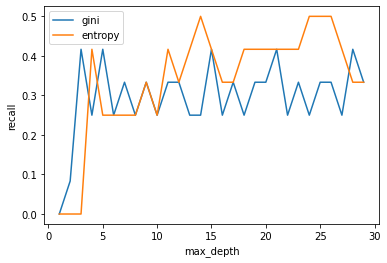

In [10]:
plt.plot("max_depth","recall_gini", data=d, label="gini")
plt.plot("max_depth","recall_entropy", data=d, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("recall")
plt.legend()

#### Plot Precision Vs Tree depth for both spliting criterions(Gini & Entopy)

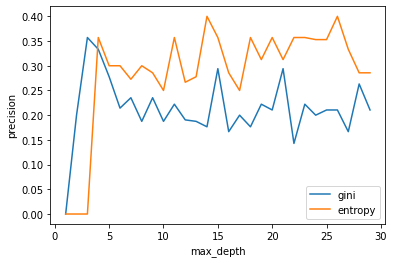

In [11]:
plt.plot("max_depth","precision_gini", data=d, label="gini")
plt.plot("max_depth","precision_entropy", data=d, label="entropy")
plt.xlabel("max_depth")
plt.ylabel("precision")
plt.legend()

#### Train the model with the best parameters.

In [12]:
Dclf=tree.DecisionTreeClassifier(criterion='gini',max_depth= 3)
Dclf=Dclf.fit(features_train, labels_train)


#### Print the peformance on the Training set

In [13]:
predLabel = Dclf.predict(features_train)
print ('-----------------------------')
print ('Confusion Matrix ','\n\n',confusion_matrix(labels_train, predLabel))
print ('Precision = ', precision_score(labels_train, predLabel, average="macro"))
print ('Recall =', recall_score(labels_train, predLabel, average="macro"))
print ('-----------------------------')

-----------------------------
Confusion Matrix  

 [[591  12]
 [ 21  16]]
Precision =  0.7685574229691876
Recall = 0.7062659674599974


-----------------------------


#### Print the peformance on the Test set

In [14]:
predLabel = Dclf.predict(features_test)
print ('-----------------------------')
print ('Confusion Matrix ','\n\n',confusion_matrix(labels_test, predLabel))
print ('Precision = ', precision_score(labels_test, predLabel, average="macro"))
print ('Recall =', recall_score(labels_test, predLabel, average="macro"))
print ('-----------------------------')
        


-----------------------------
Confusion Matrix  

 [[250  13]
 [  6   6]]
Precision =  0.6461759868421053
Recall = 0.7252851711026616


-----------------------------


#### Plot the tree

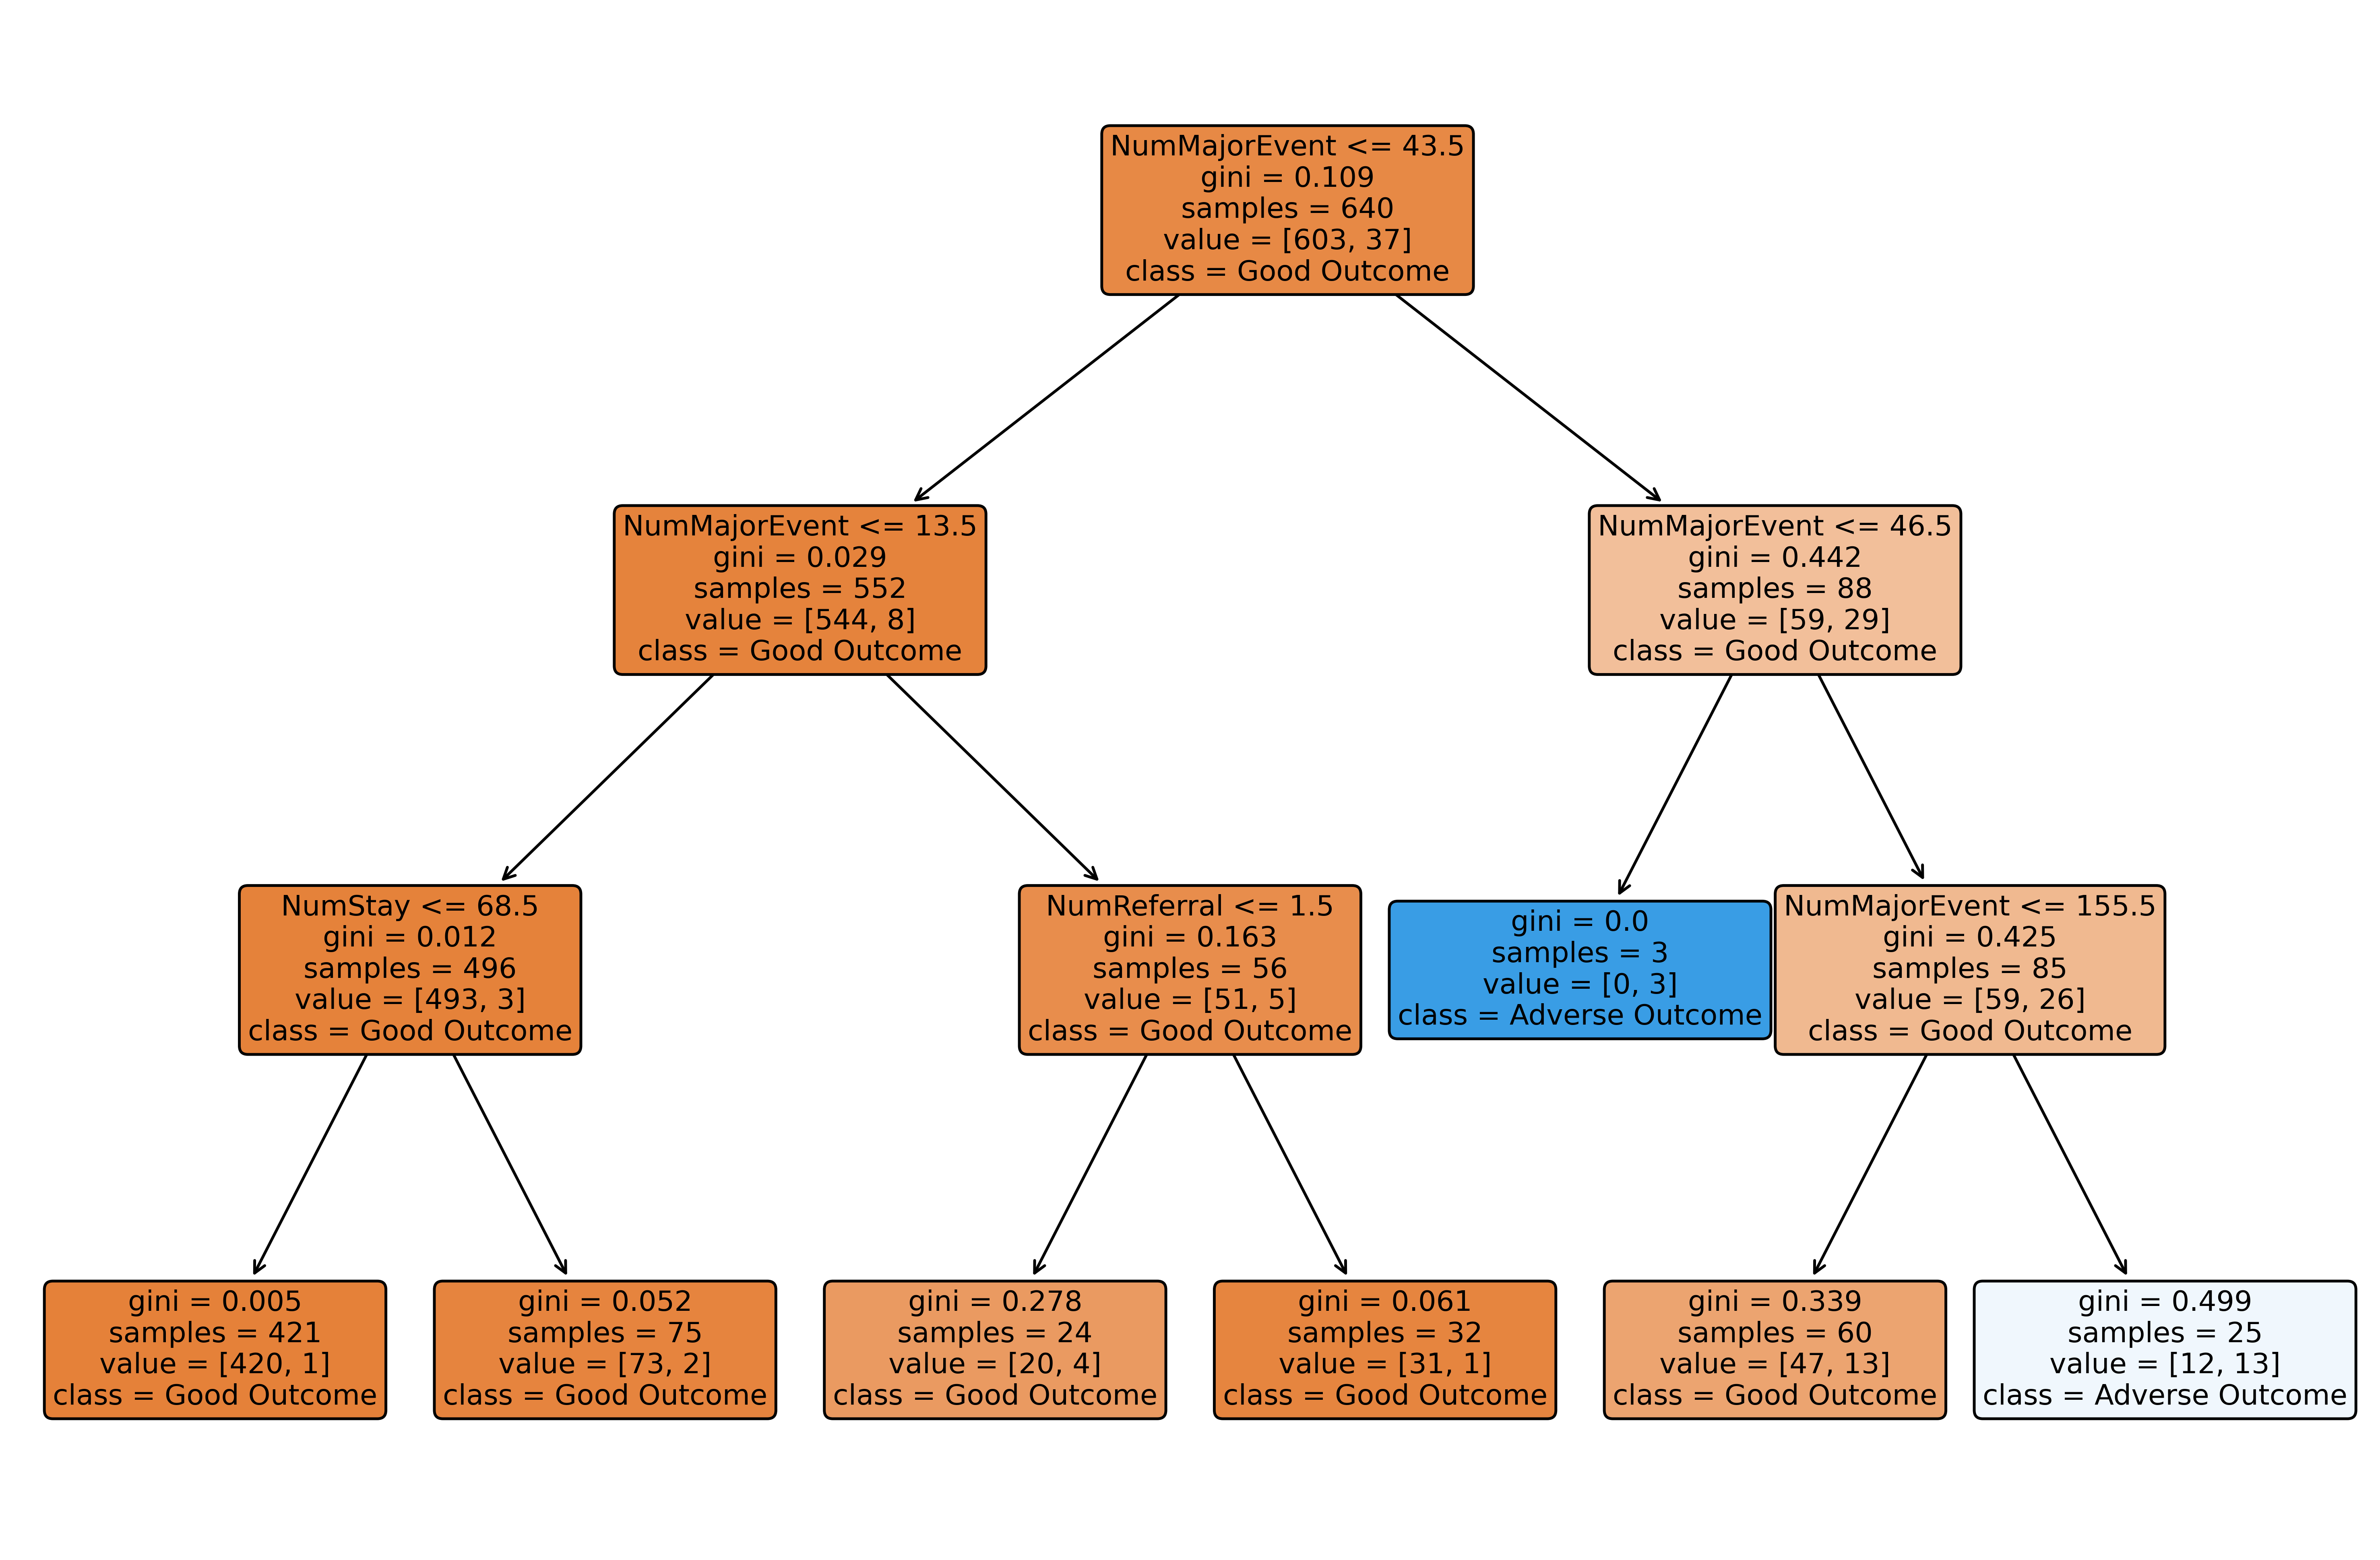

In [15]:
# Extract the feature names
FtrNames = list(features.columns)

plt.figure(figsize =(15,10),dpi = 500)
tree.plot_tree(Dclf,feature_names=FtrNames, class_names=['Good Outcome','Adverse Outcome'],
               rounded=True,filled=True);

# MiMiC Results

## Load the dataset as features and Labels

In [2]:
datFtr= pd.read_csv(f'/Users/annaa/Documents/data/MiMic_BME.csv')
datLabel= pd.read_csv(f'/Users/annaa/Documents/data/MiMic_BME_Mortality.csv')

In [3]:
datFtrs = datFtr.set_index('subject_id')
datLabels = datLabel.set_index('subject_id')

In [4]:
datFtrs=datFtrs.drop(['Unnamed: 0','Procedure_type','Service_type','Hematologic','MetaStatic','AIDS','Index_Col'], axis=1)

In [5]:
datFtrs.head() 

,Bilrubin_Level,BT,FIO2,GCSEyes,GCSMotor,GCSVerbal,HR,PAO2,Potassium_Level,SBC_Level,SBP,Sodium_Level,SUN_Level,Urin,WBCC_Level,Age
subject_id,,,,,,,,,,,,,,,,
3.0,4.252083,98.578685,0.450521,2.0,0.0,0.0,92.244792,111.859375,4.194792,15.104167,111.604167,137.218750,36.010417,67.427083,16.012500,76.0
4.0,3.397917,98.066667,0.589062,3.0,4.0,4.0,94.322917,74.000000,3.397917,21.312500,118.564941,138.687500,14.354167,151.940568,8.593750,47.0
6.0,4.610417,98.052941,0.534851,3.0,4.0,4.0,85.562500,109.437500,4.509896,15.718750,151.708333,132.229167,65.302083,86.927083,10.341667,65.0
9.0,3.287500,97.655264,0.561458,0.0,0.0,0.0,86.437500,83.302083,3.272917,24.145833,151.364583,135.520833,19.843750,164.226562,14.789583,41.0
11.0,3.879167,98.277779,0.534851,3.0,4.0,4.0,84.531250,137.627770,3.879167,26.177083,118.564941,142.218750,16.875000,151.940568,10.575000,50.0


In [164]:
# print(sorted(datLabels['Expired'].unique()))
#print(sorted(datFtrs['Procedure_type'].unique()))

## Split data into training set(70%) and test set(30%)

In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(datFtrs, datLabels, test_size=.3,stratify=datLabels)

##### Train multiple trees of diferent depths (1 to 30) and diferent splitinng criterion(Gini & Entropy) to find the best parameters to be used for the resulting tree

In [7]:
max_depth = []
precision_gini = []
precision_entropy = []
recall_gini = []
recall_entropy = []
for i in range(1,30):
    dtree = tree.DecisionTreeClassifier(criterion="gini", max_depth=i)
    dtree.fit(features_train, labels_train)
    predLabel = dtree.predict(features_test)
    precision_gini.append(precision_score(labels_test, predLabel, average="macro"))
    recall_gini.append(recall_score(labels_test, predLabel, average="macro"))

    dtree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=i)
    dtree.fit(features_train, labels_train)
    predLabel = dtree.predict(features_test)
    precision_entropy.append(precision_score(labels_test, predLabel, average="macro"))
    recall_entropy.append(recall_score(labels_test, predLabel, average="macro"))

    max_depth.append(i)
    
d = pd.DataFrame({"precision_gini":pd.Series(precision_gini), "precision_entropy":pd.Series(precision_entropy),
 "recall_gini":pd.Series(recall_gini), "recall_entropy":pd.Series(recall_entropy),
 "max_depth":pd.Series(max_depth)})

/Users/annaa/software/yes/envs/jakpa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annaa/software/yes/envs/jakpa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Plot Recall & Precision Vs Tree depth for both spliting criterions(Gini & Entopy)

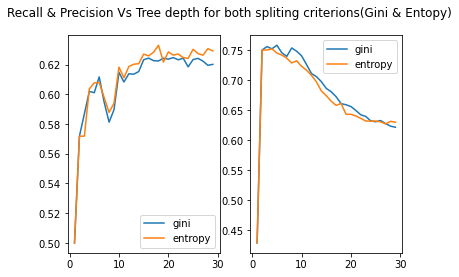

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot("max_depth","recall_gini", data=d, label="gini")
ax1.plot("max_depth","recall_entropy", data=d, label="entropy")
# ax1.xlabel("max_depth")
# ax1.ylabel("recall")
ax1.legend()

ax2.plot("max_depth","precision_gini", data=d, label="gini")
ax2.plot("max_depth","precision_entropy", data=d, label="entropy")
# ax2.xlabel("max_depth")
# ax2.ylabel("precision")
ax2.legend()
f.suptitle('Recall & Precision Vs Tree depth for both spliting criterions(Gini & Entopy)')
plt.show()

In [12]:
precision_gini[0:8]

[0.4290522102965254,
 0.7501612691473847,
 0.7558978490050585,
 0.7521296613830419,
 0.758136212730639,
 0.7456740292678672,
 0.739600205244872,
 0.7536843179215482]

In [13]:
recall_gini[0:8]

[0.5,
 0.5718577241075651,
 0.5868788832536977,
 0.6019605844653545,
 0.6011000173948022,
 0.6117525670922958,
 0.5948058169305784,
 0.5812661377559618]

#### Train the model with the best parameters.

In [11]:
Dclf=tree.DecisionTreeClassifier(criterion='gini',max_depth= 6)
Dclf=Dclf.fit(features_train, labels_train)

#### Print the peformance on the Training and Test set

In [22]:
predLabel = Dclf.predict(features_train)
print ('-----------------------------')
print ('Training set peformance')
print ('-----------------------------')
print ('Confusion Matrix ','\n',confusion_matrix(labels_train, predLabel))
print ()
print ('Precision = ', precision_score(labels_train, predLabel, average="macro"))
print ('Recall =', recall_score(labels_train, predLabel, average="macro"))
print ('Accuracy =', accuracy_score(labels_train, predLabel))
print ()

predLabel = Dclf.predict(features_test)
print ('-----------------------------')
print ('Test set peformance')
print ('-----------------------------')
print ('Confusion Matrix ','\n',confusion_matrix(labels_test, predLabel))
print ()
print ('Precision = ', precision_score(labels_test, predLabel, average="macro"))
print ('Recall =', recall_score(labels_test, predLabel, average="macro"))
print ('Accuracy =', accuracy_score(labels_test, predLabel))
    

-----------------------------
Training set peformance
-----------------------------
Confusion Matrix  
 [[21581   432]
 [ 2701   938]]

Precision =  0.786718436714108
Recall = 0.6190691772768564
Accuracy = 0.8778652736628723

-----------------------------
Test set peformance
-----------------------------
Confusion Matrix  
 [[9180  254]
 [1171  389]]

Precision =  0.7459237527932854
Recall = 0.6112175410272718
Accuracy = 0.8703838457340367


#### Plot the tree

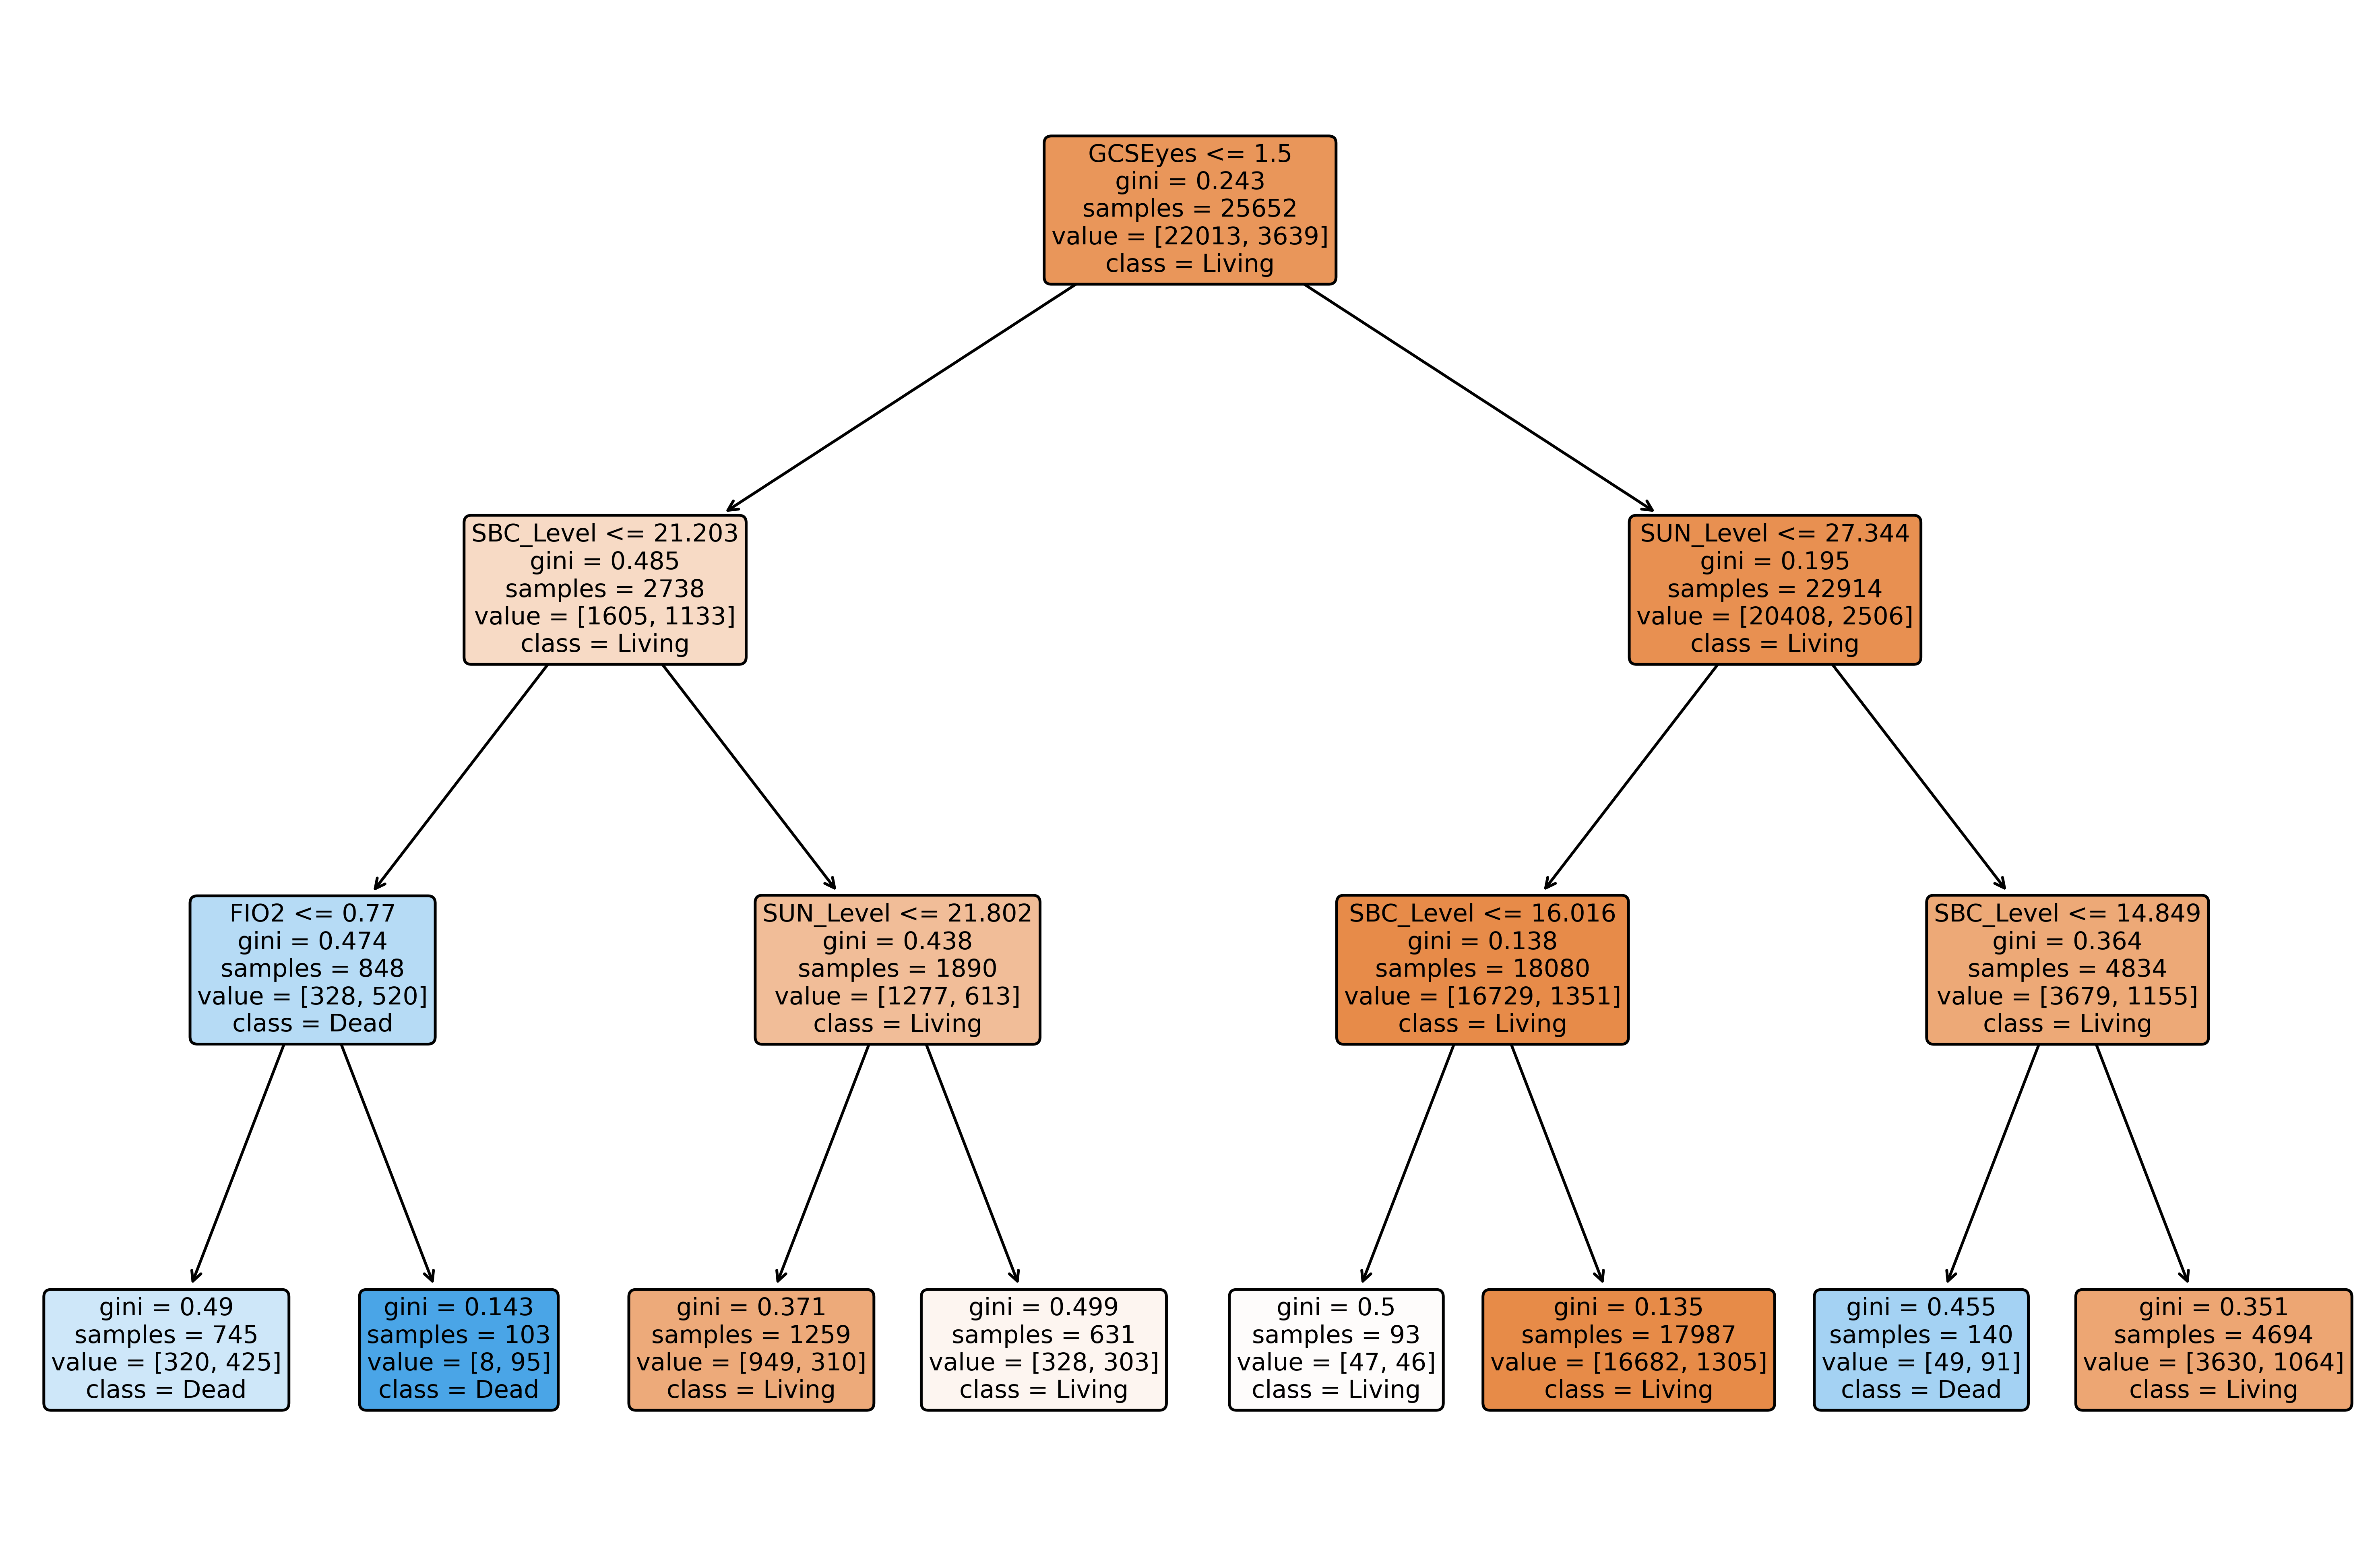

In [20]:
# Extract the feature names
FtrNames = list(datFtrs.columns)

plt.figure(figsize =(15,10),dpi = 500)
tree.plot_tree(Dclf,feature_names=FtrNames, class_names=['Living','Dead'],
               rounded=True,filled=True);

In [17]:
tree.export_graphviz(Dclf, out_file='BME.dot', feature_names=FtrNames,
                     class_names=['Living','Dead'], rounded=True, filled=True)